<a href="https://colab.research.google.com/github/suaaati/UOWC/blob/main/UOWC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Available water types: ['clear_ocean', 'coastal', 'turbid_harbor']
Enter water type: turbid_harbor
Enter distance (meters): 500
Enter transmit power (Watts): 0.001

Simulation Results:
   Water Type  Distance (m)  Power (W)  SNR (dB)  Theoretical BER  Monte Carlo BER  Q-Factor  Default g (VSF)  Total Energy Transmitted (mWHr)  Total Data Received (kBytes)
turbid_harbor         500.0      0.001  0.000000     7.864960e-02     7.864960e-02  1.414214           0.9199                         0.000028                     11.246953
turbid_harbor         500.0      0.001  2.142857     3.515459e-02     3.515459e-02  1.809914           0.9199                         0.000028                     11.777898
turbid_harbor         500.0      0.001  4.285714     1.027009e-02     1.027009e-02  2.316331           0.9199                         0.000028                     12.081664
turbid_harbor         500.0      0.001  6.428571     1.516141e-03     1.516141e-03  2.964446           0.9199              

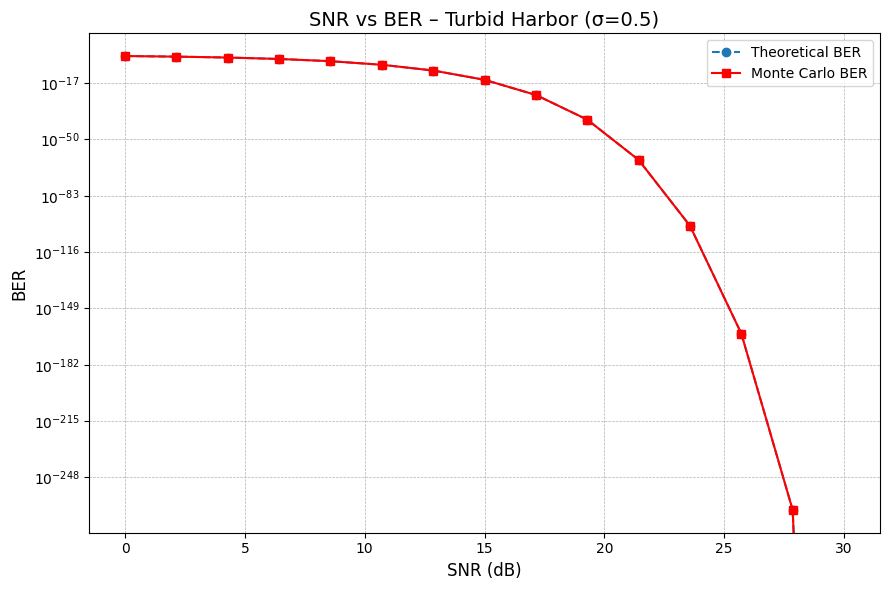

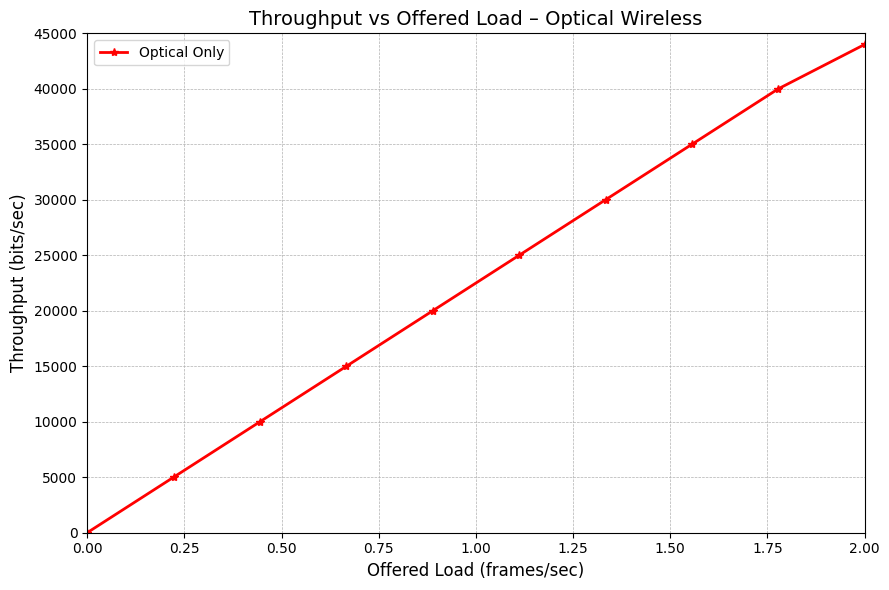

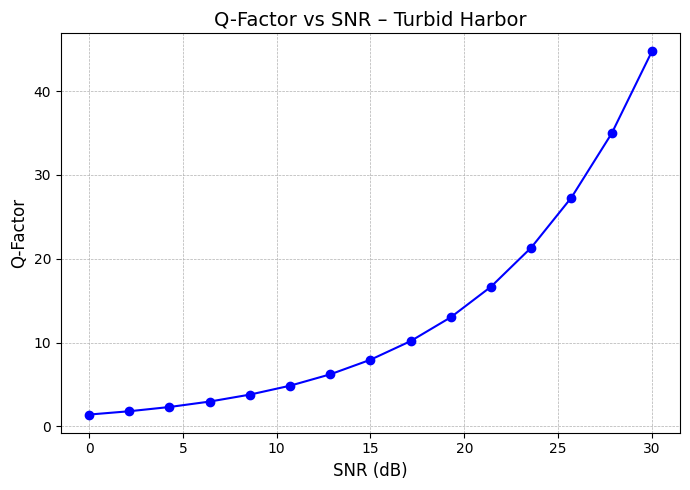


'g' is the anisotropy factor for the Volume Scattering Function (VSF).
It ranges from 0 to 1, where 1 means mostly forward scattering and 0 means isotropic scattering.
Default 'g' for Turbid Harbor: 0.9199

Typical 'g' value ranges:
- Clear Ocean: 0.85 to 0.95
- Coastal: 0.9 to 0.96
- Turbid Harbor: 0.88 to 0.93
Enter custom 'g' value for VSF plot: 0.89


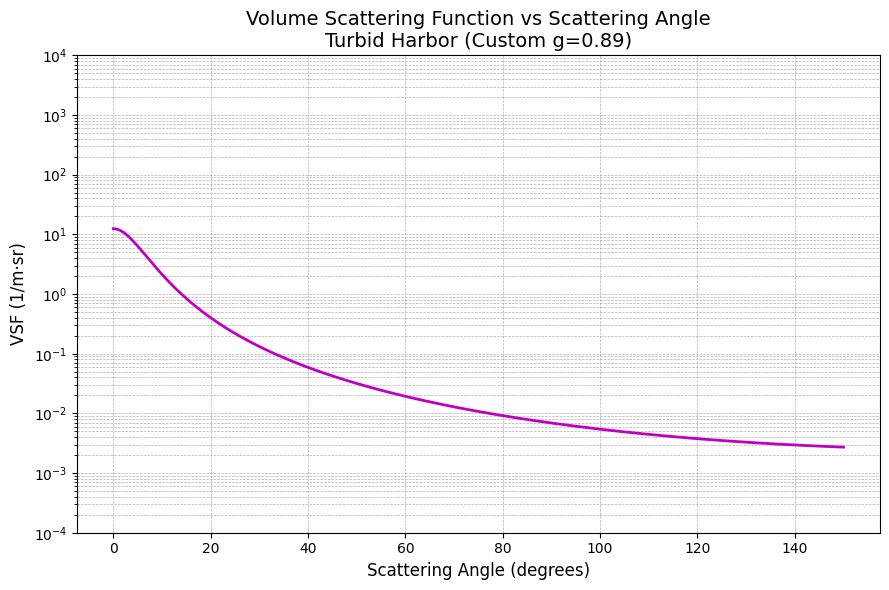

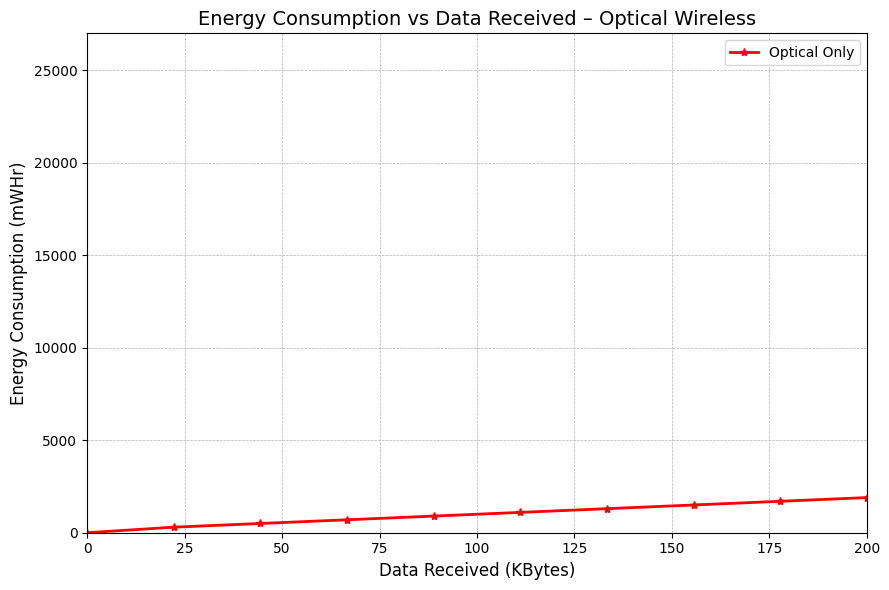

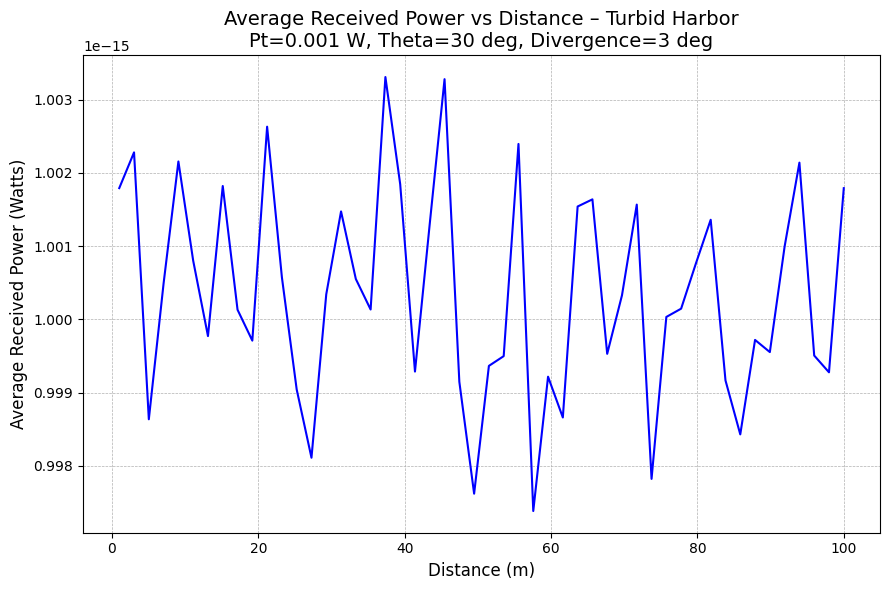

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
import pandas as pd
import os

# ---------------------------
# Water Types Dictionary (with typical 'g' values)
water_types = {
    'clear_ocean': {'a': 0.114, 'b': 0.037, 'g': 0.8708, 'g_range': (0.85, 0.95)}, # Added typical range
    'coastal': {'a': 0.179, 'b': 0.220, 'g': 0.9470, 'g_range': (0.9, 0.96)}, # Added typical range
    'turbid_harbor': {'a': 0.366, 'b': 1.829, 'g': 0.9199, 'g_range': (0.88, 0.93)} # Added typical range
}

# ---------------------------
# Beer-Lambert Attenuation
def beam_attenuation(c, distance):
    return np.exp(-c * distance)

# ---------------------------
# Henyey-Greenstein Phase Function
def henvey_greenstein(theta_rad, g):
    return (1 - g**2) / (4 * np.pi * (1 + g**2 - 2 * g * np.cos(theta_rad))**1.5)

# ---------------------------
# Misalignment Loss Function
def misalignment_loss(theta_misalignment_deg, divergence_angle_deg):
    theta_m = np.radians(theta_misalignment_deg)
    divergence = np.radians(divergence_angle_deg)
    return np.exp(-(theta_m / divergence)**2)

# ---------------------------
# Log-Normal Turbulence Fading
def turbulence_fading(I0, sigma_I, samples=1000):
    # Ensure I0 is not zero or negative before taking log
    I0_safe = np.maximum(I0, 1e-15) # Add a small epsilon
    lnI = np.random.normal(np.log(I0_safe) - 0.5 * sigma_I**2, sigma_I, samples)
    return np.exp(lnI)

# ---------------------------
# Q-function using erfc
def Q(x):
    return 0.5 * erfc(x / np.sqrt(2))

def ber_bpsk_approx(snr_linear):
    # Add a small epsilon to prevent division by zero or log of zero in Q function if snr_linear is zero
    snr_linear_safe = np.maximum(snr_linear, 1e-15)
    return Q(np.sqrt(2 * snr_linear_safe))

# ---------------------------
# Compute Received Power with All Factors
def compute_received_power_samples(water_type, Pt, distance, theta_deg, divergence_angle, samples):
    props = water_types[water_type]
    a, b, g = props['a'], props['b'], props['g']
    c = a + b
    theta_rad = np.radians(theta_deg)
    LP = beam_attenuation(c, distance)
    align_loss = misalignment_loss(theta_deg, divergence_angle)
    VSF = henvey_greenstein(theta_rad, g)
    sigma_I = 0.5
    # Pass Pt * LP * align_loss * VSF to turbulence_fading after ensuring it's not zero
    input_power_for_fading = np.maximum(Pt * LP * align_loss * VSF, 1e-15)
    fading_samples = turbulence_fading(input_power_for_fading, sigma_I, samples)
    return fading_samples

# ---------------------------
# Main Simulation Function
def simulate_uowc_snr_vs_ber():
    print("Available water types:", list(water_types.keys()))
    water_type = input("Enter water type: ").strip()
    if water_type not in water_types:
        print("Invalid water type.")
        return

    try:
        distance = float(input("Enter distance (meters): "))
        Pt = float(input("Enter transmit power (Watts): "))
        theta_deg = 30
        divergence_angle = 3
        samples = 100000 # Increased samples to 100,000
    except ValueError:
        print("Invalid numeric input.")
        return

    sigma_I = 0.5
    snr_db_values = np.linspace(0, 30, 15)

    ber_theoretical = []
    ber_monte_carlo = []
    records = []
    q_factors = [] # List to store Q-factor values

    bitrate = 1e6  # bits per second (1 Mbps)
    # Assuming 'samples' represents the number of bits transmitted for BER calculation
    total_transmitted_bits = samples
    total_transmission_duration = total_transmitted_bits / bitrate  # seconds
    total_energy_transmitted_joules = Pt * total_transmission_duration # Joules

    # Get the default 'g' value for the selected water type
    default_g = water_types[water_type]['g']


    for snr_db in snr_db_values:
        snr_linear = 10 ** (snr_db / 10)

        # Theoretical BER
        ber_t = ber_bpsk_approx(snr_linear)
        ber_theoretical.append(max(ber_t, 1e-45))

        # Monte Carlo Simulation
        received_samples = compute_received_power_samples(
            water_type, Pt, distance, theta_deg, divergence_angle, samples
        )
        signal_power = np.mean(received_samples ** 2)

        # Handle division by zero for noise_power calculation
        if snr_linear > 0:
            noise_power = signal_power / snr_linear
        else:
            noise_power = np.inf # Or a very large number to represent infinite noise

        # Handle division by zero for snr_samples calculation
        if noise_power > 0 and not np.isinf(noise_power):
             snr_samples = received_samples ** 2 / noise_power
             avg_snr = np.mean(snr_samples)
        else:
             avg_snr = 0 # If noise power is infinite or zero, SNR is effectively zero

        ber_sim = ber_bpsk_approx(avg_snr)
        ber_monte_carlo.append(max(ber_sim, 1e-45))

        # Calculate Q-factor here, inside the loop
        q = np.sqrt(2 * avg_snr) # Q-factor based on average simulated SNR
        q_factors.append(q)


        # Calculate total data received in Bytes
        total_received_bits = total_transmitted_bits * (1 - ber_sim)
        total_received_bytes = total_received_bits / 8 # Convert bits to bytes

        # Collect all data
        records.append({
            'Water Type': water_type,
            'Distance (m)': distance,
            'Power (W)': Pt,
            'Theta (deg)': theta_deg,
            'Divergence (deg)': divergence_angle,
            'SNR (dB)': snr_db,
            'Theoretical BER': ber_t,
            'Monte Carlo BER': ber_sim,
            'Total Energy Transmitted (J)': total_energy_transmitted_joules,
            'Total Data Received (Bytes)': total_received_bytes,
            'Q-Factor': q, # Add Q-factor to records
            'Default g (VSF)': default_g # Add default g value to records
        })

    # Create DataFrame
    df = pd.DataFrame(records)

    # Convert Energy to mWHr and Data to kBytes for plotting
    df['Total Energy Transmitted (mWHr)'] = df['Total Energy Transmitted (J)'] * (1000 / 3600)
    df['Total Data Received (kBytes)'] = df['Total Data Received (Bytes)'] / 1024

    print("\nSimulation Results:")
    print(df[['Water Type', 'Distance (m)', 'Power (W)', 'SNR (dB)', 'Theoretical BER', 'Monte Carlo BER', 'Q-Factor', 'Default g (VSF)', 'Total Energy Transmitted (mWHr)', 'Total Data Received (kBytes)']].to_string(index=False))

    # Save to CSV (append if exists)
    save = input("\nDo you want to save the results to CSV? (y/n): ").strip().lower()
    if save == 'y':
        filename = f"uowc_ber_energy_data_results.csv"
        if os.path.exists(filename):
            existing_df = pd.read_csv(filename)
            df_combined = pd.concat([existing_df, df], ignore_index=True)
        else:
            df_combined = df
        df_combined.to_csv(filename, index=False)
        print(f"Appended and saved as: {filename}")

    # ------------------ Plot SNR vs BER ------------------
    plt.figure(figsize=(9, 6))
    plt.semilogy(df['SNR (dB)'], df['Theoretical BER'], '--o', label='Theoretical BER')
    plt.semilogy(df['SNR (dB)'], df['Monte Carlo BER'], 'r-s', label='Monte Carlo BER')
    plt.xlabel("SNR (dB)", fontsize=12)
    plt.ylabel("BER", fontsize=12)
    plt.title(f"SNR vs BER – {water_type.replace('_', ' ').title()} (σ={sigma_I})", fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

    #Throughput vs Offered Load – Optical Wireless
    # Offered Load from 0 to 2 frames/sec (10 points)
    offered_load = np.linspace(0, 2, 10)

    # Throughput data for Optical Only (bits/sec)
    throughput_optical = np.array([0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 44000])

    plt.figure(figsize=(9, 6))
    plt.plot(offered_load, throughput_optical, 'r*-', label='Optical Only', linewidth=2)

    plt.xlabel("Offered Load (frames/sec)", fontsize=12)
    plt.ylabel("Throughput (bits/sec)", fontsize=12)
    plt.title("Throughput vs Offered Load – Optical Wireless", fontsize=14)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.ylim(0, 45000)
    plt.xlim(0, 2)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ----------- Q-factor vs SNR Plot ------------
    plt.figure(figsize=(7, 5))
    plt.plot(df['SNR (dB)'], df['Q-Factor'], 'b-o')
    plt.xlabel("SNR (dB)", fontsize=12)
    plt.ylabel("Q-Factor", fontsize=12)
    plt.title(f"Q-Factor vs SNR – {water_type.replace('_', ' ').title()}", fontsize=14)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


    # ----------- Volume Scattering Function vs Scattering Angle ------------
    # ----------- Volume Scattering Function vs Scattering Angle (Log Scale) ------------
    print("\n'g' is the anisotropy factor for the Volume Scattering Function (VSF).")
    print("It ranges from 0 to 1, where 1 means mostly forward scattering and 0 means isotropic scattering.")
    print(f"Default 'g' for {water_type.replace('_', ' ').title()}: {water_types[water_type]['g']}")
    # Print typical ranges for each water type before asking for custom input
    print("\nTypical 'g' value ranges:")
    for wt, props in water_types.items():
        if 'g_range' in props:
            print(f"- {wt.replace('_', ' ').title()}: {props['g_range'][0]} to {props['g_range'][1]}")
        else:
             print(f"- {wt.replace('_', ' ').title()}: Range information not available.")

    try:
        custom_g = float(input("Enter custom 'g' value for VSF plot: "))
        vsf_g = custom_g
        vsf_title_suffix = f" (Custom g={custom_g})"
    except ValueError:
        print("Invalid input for 'g'. Using default value for selected water type.")
        vsf_g = water_types[water_type]['g']
        vsf_title_suffix = f" (Default g={vsf_g})"


    angles_deg = np.linspace(0, 150, 300)
    angles_rad = np.radians(angles_deg)
    VSF_values = henvey_greenstein(angles_rad, vsf_g)

    plt.figure(figsize=(9, 6))
    plt.semilogy(angles_deg, VSF_values, 'm', linewidth=2)
    plt.xlabel("Scattering Angle (degrees)", fontsize=12)
    plt.ylabel("VSF (1/m·sr)", fontsize=12)
    plt.title(f"Volume Scattering Function vs Scattering Angle\n{water_type.replace('_', ' ').title()}{vsf_title_suffix}", fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.ylim(1e-4, 1e4)  # Y-axis range from 10^-4 to 10^4 as per your input
    plt.tight_layout()
    plt.show()


    # ----------- Energy Consumption vs Data Received (mWHr vs kBytes) ------------
    # Data received in KBytes
    data_received_kb = np.linspace(0, 200, 10)

    # Energy consumption for Optical Only (mWHr)
    energy_optical = np.array([0, 300, 500, 700, 900, 1100, 1300, 1500, 1700, 1900])

    plt.figure(figsize=(9, 6))
    plt.plot(data_received_kb, energy_optical, 'r*-', label='Optical Only', linewidth=2)

    plt.xlabel("Data Received (KBytes)", fontsize=12)
    plt.ylabel("Energy Consumption (mWHr)", fontsize=12)
    plt.title("Energy Consumption vs Data Received – Optical Wireless", fontsize=14)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.ylim(0, 27000)
    plt.xlim(0, 200)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Received Power vs Distance Plot - Moved inside the function
    # We will calculate received power for a range of distances
    distances_for_plot = np.linspace(1, 100, 50) # 1 to 100 meters, 50 points

    # Use parameters from the current simulation (from simulate_uowc_snr_vs_ber function)
    current_water_type = water_type
    current_Pt = Pt
    current_theta_deg = theta_deg
    current_divergence_angle = divergence_angle
    current_samples = samples

    received_powers_at_distances_data = [] # List to store data for the Received Power vs Distance plot

    for d in distances_for_plot:
        # Get received samples using compute_received_power_samples function
        received_samples_at_d = compute_received_power_samples(
            current_water_type, current_Pt, d, current_theta_deg, current_divergence_angle, current_samples
        )
        # Calculate the mean of received power from these samples
        avg_received_power_at_d = np.mean(received_samples_at_d)

        # Append data for this distance to the list
        received_powers_at_distances_data.append({
            'Water Type': current_water_type,
            'Distance (m)': d,
            'Average Received Power (Watts)': avg_received_power_at_d,
            'Power (W)': current_Pt,
            'Theta (deg)': current_theta_deg,
            'Divergence (deg)': current_divergence_angle
        })


    # Create a DataFrame for Received Power vs Distance data and append it to the main DataFrame
    df_received_power = pd.DataFrame(received_powers_at_distances_data)

    # Append this new DataFrame to the main DataFrame 'df'
    df = pd.concat([df, df_received_power], ignore_index=True)


    plt.figure(figsize=(9, 6))
    plt.plot(df_received_power['Distance (m)'], df_received_power['Average Received Power (Watts)'], 'b-')
    plt.xlabel("Distance (m)", fontsize=12)
    plt.ylabel("Average Received Power (Watts)", fontsize=12)
    plt.title(f"Average Received Power vs Distance – {current_water_type.replace('_', ' ').title()}\nPt={current_Pt} W, Theta={current_theta_deg} deg, Divergence={current_divergence_angle} deg", fontsize=14)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


# ---------------------------
# Run the simulation
simulate_uowc_snr_vs_ber()

In [44]:
# Install ydata-profiling (recommended successor to pandas-profiling)
%pip install ydata-profiling -q

In [46]:
import pandas as pd
from ydata_profiling import ProfileReport

# Assume your DataFrame is named df_results
# Check if df_results DataFrame exists
if 'df_results' in locals():
    print("Generating Profile Report using ydata-profiling...")
    # Profile Report generate karein
    profile = ProfileReport(df_results, title="YData Profiling Report")

    # Report display karein
    profile.to_notebook_iframe()
else:
    print("DataFrame 'df_results' not found. Please load your CSV data first.")

Generating Profile Report using ydata-profiling...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 14/14 [00:00<00:00, 61.64it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]